In [1]:
import math
from __future__ import division
from collections import OrderedDict
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import histbook as hb
from vega import VegaLite as canvas

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [2]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [3]:
import fnal_column_analysis_tools.lookup_tools as lookup_tools
import cloudpickle
import zlib

# import a bunch of correction histograms
weightsext = lookup_tools.extractor()
correctionDescriptions = open("newCorrectionFiles.txt").readlines()
weightsext.add_weight_sets(correctionDescriptions)
weightsext.finalize()
weights_eval = weightsext.make_evaluator()
#let's pickle and zip it
weights_names = zlib.compress(cloudpickle.dumps(weightsext._extractor__names))
weights_vals = zlib.compress(cloudpickle.dumps(weightsext._extractor__weights))

#dir(weights_eval)
#print(weights_eval["muScaleFactor_TightId_Iso"])

In [4]:
all_hists = OrderedDict()
cat = hb.groupby("category", keeporder=True)

def add_1d(*args):
    h = hb.Hist(hb.bin(*args), cat)
    all_hists[args[0]] = h
    return h

add_1d("leadingLeptonPt", 100, 0, 500)
add_1d("zMass", 120, 0, 120)

display_opts = {'width': 300, 'height': 300}
def buildDisplay(hists, cols=2):
    rows = []
    for iRow in range(int(math.ceil(len(hists)/cols))):
        hrowname = hists.keys()[iRow*cols:(iRow+1)*cols]
        hrow = hists.values()[iRow*cols:(iRow+1)*cols]
        rows.append(hb.beside(*tuple(h.overlay("category").step(n, **display_opts) for h,n in zip(hrow, hrowname))))
    return IPythonDisplay(
        hb.below(*tuple(rows))
    )
    
display = buildDisplay(all_hists)

class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()

profile = hb.Hist(hb.bin("stripeThroughput", 100, 0, 5.e5), hb.groupby("operation", keeporder=True))

In [5]:
#__worker_class__
    
#__worker_class__
    
# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import
    #import subprocess
    #raise Exception(subprocess.check_output("pip list".split(" ")))
    
import numpy as np
import awkward
import uproot_methods
import cloudpickle
import zlib
import time
from collections import OrderedDict
from functools import reduce
#import fnal_column_analysis_tools

class denselookup(object):
    def __init__(self,values,dims): 
        self.__dimension = 0
        whattype = type(dims)
        if whattype == np.ndarray:
            self.__dimension = 1
        else:
            self.__dimension = len(dims)        
        if self.__dimension == 0:
            raise Exception('Could not define dimension for {}'.format(whattype))
        self.__axes = dims
        self.__values = values
        self.__type = type(self.__values)
    
    def __call__(self,*args):        
        inputs = list(args)
        #print inputs
        offsets = None
        #print
        for i in xrange(len(inputs)):
            #print i,type(inputs[i])
            if isinstance(inputs[i], awkward.JaggedArray):
                if offsets is not None and offsets.base is not inputs[i].offsets.base:
                    if type(offsets) is int:
                        raise Exception('do not mix JaggedArrays and numpy arrays when calling denselookup')
                    else:
                        raise Exception('All input jagged arrays must have a common structure (offsets)!')
                offsets = inputs[i].offsets
                inputs[i] = inputs[i].content # TODO: check can use offsets (should always be true for striped)
                #print type(inputs[i])
            elif isinstance(inputs[i], np.ndarray):
                offsets = -1
        retval = self.__evaluate(*tuple(inputs))
        if offsets is not None and type(offsets) is not int:
            retval = awkward.JaggedArray.fromoffsets(offsets,retval)
        #print retval
        #print
        return retval
                                               
    
    def __evaluate(self,*args):        
        indices = [] 
        for arg in args: 
            if type(arg) == awkward.JaggedArray: raise Exception('JaggedArray in inputs')
        if self.__dimension == 1:
            indices.append(np.clip(np.searchsorted(self.__axes, args[0], side='right')-1,0,self.__values.shape[0]-1))
        else:
            for dim in xrange(self.__dimension):
                #print self.__axes[dim], self.__values.shape
                indices.append(np.clip(np.searchsorted(self.__axes[dim], args[dim], side='right')-1,0,self.__values.shape[len(self.__axes)-dim-1]-1))
        indices.reverse()
        return self.__values[tuple(indices)]
    
    def __repr__(self):
        myrepr = "{} dimensional histogram with axes:\n".format(self.__dimension)
        temp = "" 
        if self.__dimension == 1:
            temp = "\t1: {}\n".format(self.__axes)
        else:
            temp = "\t1: {}\n".format(self.__axes[0])
        for idim in xrange(1,self.__dimension):
            temp += "\t{}: {}\n".format(idim+1,self.__axes[idim])        
        myrepr += temp
        return myrepr

class evaluator(object):
    def __init__(self,names,primitives):
        self.__functions = {}
        for key, idx in names.iteritems():
            self.__functions[key] = denselookup(*primitives[idx])
            
    def __dir__(self):
        return self.__functions.keys()
        
    def __getitem__(self, key):
        return self.__functions[key]


def p4_pt(p4):
    # p4 is [n,4] numpy array
    # returns [n] numpy array
    return np.sqrt(p4[:,0]**2 + p4[:,1]**2)

def p4_eta(p4):
    p42 = p4**2
    p3 = np.sqrt(np.sum(p42[:,:3], axis=-1))
    return p4[:,2]/p3


JaggedWithLorentz = awkward.Methods.mixin(uproot_methods.classes.TLorentzVector.ArrayMethods, awkward.JaggedArray)

class JaggedDecoratedFourVector(awkward.JaggedArray,):
    def __init__(self,jagged):        
        super(JaggedDecoratedFourVector, self).__init__(jagged.starts,
                                                        jagged.stops,
                                                        jagged.content)
        if 'p4' not in self.columns:
            raise Exception('JaggedDecoratedFourVector declared without "p4" column: {}'.format(self.columns))
        
        self._ispair = False
        self._iscross = False
        if hasattr(jagged,'_ispair'):
            self._ispair = jagged._ispair
        if hasattr(jagged,'_iscross'):
            self._iscross = jagged._iscross
        
    @classmethod
    def fromcounts(cls,counts,p4,**kwargs):
        the_p4 = p4
        if not isinstance(p4,uproot_methods.TLorentzVectorArray):
            the_p4 = uproot_methods.TLorentzVectorArray(p4[:,0],p4[:,1],p4[:,2],p4[:,3])
        items = {'p4':the_p4}
        items.update(kwargs)
        return JaggedDecoratedFourVector(awkward.JaggedArray.fromcounts(counts,awkward.Table(items)))
    
    @property
    def p4(self):
        return self['p4']
    
    def at(self,what):
        raw = super(JaggedDecoratedFourVector,self).at(what)
        if 'p4' in raw.columns:
            return JaggedDecoratedFourVector(raw)
        if( np.sum(raw.counts) == 0):
            raise Exception("{}".format(raw.columns))
    
        return raw
    
    def distincts(self):
        return self.pairs(same=False)
    
    def pairs(self, same=True):
        outs = super(JaggedDecoratedFourVector, self).pairs(same)        
        if( sum(outs.counts) > 0 ):
            outs['p4'] = outs.at(0)['p4'] + outs.at(1)['p4']
        else:
            outs['p4'] = JaggedWithLorentz.fromcounts(outs.counts,[])        
        outs._ispair = True
        return JaggedDecoratedFourVector(outs)
    
    def cross(self, other):
        outs = super(JaggedDecoratedFourVector, self).cross(other)
        #currently JaggedArray.cross() has some funny behavior when it encounters the
        # p4 column and make some wierd new column... for now I just delete it and reorder
        # everything looks ok after that
        if outs._iscross:
            keys = outs.columns
            reorder = False
            for key in keys:
                if not isinstance(outs[key].content,awkward.array.table.Table):
                    del outs[key]
                    reorder = True
            if reorder:
                keys = outs.columns
                realkey = {}
                for i in xrange(len(keys)):
                    realkey[keys[i]] = str(i)
                for key in keys:
                    if realkey[key] != key:
                        outs[realkey[key]] = outs[key]
                        del outs[key]
            keys = outs.columns
            for key in keys:                    
                if 'p4' not in outs.columns:
                    outs['p4'] = outs.at(int(key))['p4']
                else:
                    outs['p4'] = outs['p4'] + outs.at(int(key))['p4']
        else:
            outs['p4'] = outs.at(0)['p4'] + outs.at(1)['p4']
            outs._iscross = True
        return JaggedDecoratedFourVector(outs)
    
    def __getattr__(self,what):
        if what in self.columns:
            return self[what]
        if what[0] == '_' and what[1:].isdigit() :
            return self[what[1:]]
        return getattr(super(JaggedDecoratedFourVector,self),what)

class ColumnGroup(object):
    def __init__(self,events,objName,*args):
        self.__map = {}        
        eventObj = getattr(events,objName)
        self.__counts = getattr(events,objName).count        
        for arg in args:
            callStack = arg.split('.')
            retval = getattr(eventObj,callStack[0])
            for i in xrange(1,len(callStack)):
                retval = getattr(retval,callStack[i])
            self.__map[arg] = retval
            
    def __getitem__(self,name):
        return self.__map[name]
    
    def columnsWithout(self,toremove):
        out = {}
        out.update(self.__map)
        if isinstance(toremove,str):
            del out[toremove]
        else:
            for key in toremove:
                del out[key]
        return out
    
    def columns(self):
        return self.__map
    
    def counts(self):
        return self.__counts
    
class PhysicalColumnGroup(ColumnGroup):
    def __init__(self,events,objName,p4Name,*args):
        self.__p4  = p4Name
        allargs = [p4Name]
        allargs.extend(args)        
        super(PhysicalColumnGroup,self).__init__(events,objName,*allargs)
        if p4Name is not None:
            self.setP4Name(p4Name)
    
    def setP4Name(self,name):
        if name not in self.columns().keys():
            raise Exception('{} not an available name in this PhysicalColumnGroup'.format(name))
        self.__p4 = name
    
    def p4Name(self):
        if self.__p4 is None:
            raise Exception('p4 is not set for this PhysicalColumnGroup')
        return self.__p4
    
    def p4Column(self):        
        return self[self.p4Name()]
    
    def otherColumns(self):
        return self.columnsWithout(self.p4Name())

def jaggedFromColumnGroup(cgroup):
    if isinstance(cgroup,PhysicalColumnGroup):
        return JaggedDecoratedFourVector.fromcounts(counts = cgroup.counts(),
                                                    p4 = cgroup.p4Column(),
                                                    **cgroup.otherColumns())
    else:
        return awkward.JaggedArray.fromcounts(cgroup.counts(),
                                              awkward.Table(cgroup.columns()))
    
class Worker(object):
    def __init__(self):
        self.Columns = ["Electron.charge", "Electron.p4", "Electron.tightID",
                        "Muon.charge", "Muon.p4", "Muon.tightID",
                        "Trigger.pass"]
        self._weights_cached = None
        
    def run(self, events, job):
        times = OrderedDict()
        times['start'] = time.time()
        
        for c in self.Columns:
            _ = reduce(lambda l,r: getattr(l,r), [events]+c.split('.')).shape
        times['de-futureize'] = time.time()
        
        try:
            weights_eval = job['weights_eval']
        except KeyError:
            weights_eval = evaluator(cloudpickle.loads(zlib.decompress(job["weights_names"])),
                                 cloudpickle.loads(zlib.decompress(job["weights_vals"])))
            job.UserParams['weights_eval'] = weights_eval
            
            
        times['cache weights'] = time.time()

        #35: HLT_Ele32_WPTight_Gsf_v
        #36: HLT_Ele35_WPTight_Gsf_v
        #45: HLT_IsoMu20_v
        #46: HLT_IsoMu22_v
        #48: HLT_IsoMu24_v
        #50: HLT_IsoMu27_v
        #only care about processing events which have triggered
        #events_triggered = events.filter()
        trigger_bits = getattr(events.Trigger, "pass").reshape(-1, events.Trigger.count[0])
        good_trigger = trigger_bits[:,[35,36,45,46,48,50]].sum(axis=1) > 0
        
        times['trigger'] = time.time()
        #events = events_triggered(events)
        
        electronCols = PhysicalColumnGroup(events,"Electron","p4","charge","tightID")
        electrons_new = jaggedFromColumnGroup(electronCols)  
        electrons_new['SF'] = weights_eval["eleScaleFactor_TightId_POG"](electrons_new.p4.eta,
                                                                         electrons_new.p4.pt)
        times['electron'] = time.time()

        muonCols = PhysicalColumnGroup(events,"Muon","p4","charge","tightID")
        muons_new = jaggedFromColumnGroup(muonCols)
        muons_new['SF'] = weights_eval["muScaleFactor_TightId_Iso"](np.absolute(muons_new.p4.eta),
                                                                    muons_new.p4.pt)
        
        times['muon'] = time.time()
        
        selected_electrons = electrons_new[(electrons_new.p4.pt > 20) &
                                           (np.absolute(electrons_new.p4.eta) < 2.5) &
                                           (electrons_new.tightID > 0)]
        
        selected_muons = muons_new[(muons_new.p4.pt > 20) &
                                   (np.absolute(muons_new.p4.eta) < 2.5) &
                                   (muons_new.tightID > 0)]
        
        dielectrons = selected_electrons.distincts()
        dimuons = selected_muons.distincts()
# slower        
#         dielectrons = electrons_new.distincts()
#         dielectron_selection = (dielectrons.at(0).p4.pt > 20) & (dielectrons.at(1).p4.pt > 20) \
#                         & (np.abs(dielectrons.at(0).p4.eta) < 2.5) & (np.abs(dielectrons.at(1).p4.eta) < 2.5) \
#                         & (dielectrons.at(0).tightID > 0) & (dielectrons.at(1).tightID > 0)
        
#         dimuons = muons_new.distincts()
#         dimuon_selection = (dimuons.at(0).p4.pt > 20) & (dimuons.at(1).p4.pt > 20) \
#                         & (np.abs(dimuons.at(0).p4.eta) < 2.5) & (np.abs(dimuons.at(1).p4.eta) < 2.5) \
#                         & (dimuons.at(0).tightID > 0) & (dimuons.at(1).tightID > 0)
        
        times['good distinct'] = time.time()
        
        selected_dielectrons = dielectrons[good_trigger & ((dielectrons.at(0).p4.pt > 38) | (dielectrons.at(1).p4.pt > 38))]
        selected_dimuons = dimuons[good_trigger & ((dimuons.at(0).p4.pt > 30) | (dimuons.at(1).p4.pt > 30))]

        zee_cat = ((selected_dielectrons.counts == 1) & 
                   (selected_dimuons.counts == 0))
        
        times['cats'] = time.time()
        
        #fill electrons
        job.fill(
            category="ee",
            leadingLeptonPt=np.maximum(selected_dielectrons[zee_cat].at(0).p4.pt,
                                       selected_dielectrons[zee_cat].at(1).p4.pt).flatten()
        )        
        job.fill(
            category="ee",
            zMass=selected_dielectrons[zee_cat].p4.mass.flatten()
        )

        zmm_cat = ((selected_dimuons.counts == 1) & 
                   (selected_dielectrons.counts == 0) &
                   good_trigger)
        #fill muons
        job.fill(
            category="mm",
            leadingLeptonPt=np.maximum(selected_dimuons[zmm_cat].at(0).p4.pt,
                                       selected_dimuons[zmm_cat].at(1).p4.pt).flatten()
        )        
        job.fill(
            category="mm",
            zMass=selected_dimuons[zmm_cat].p4.mass.flatten()
        )
           
        #fill both
        job.fill(
            category="all",
            leadingLeptonPt=np.hstack([np.maximum(selected_dimuons[zmm_cat].at(0).p4.pt,
                                                  selected_dimuons[zmm_cat].at(1).p4.pt).flatten(), 
                                       np.maximum(selected_dielectrons[zee_cat].at(0).p4.pt,
                                                  selected_dielectrons[zee_cat].at(1).p4.pt).flatten()]),
        )
        job.fill(
            category="all",            
            zMass=np.hstack([selected_dielectrons[zee_cat].p4.mass.flatten(), 
                             selected_dimuons[zmm_cat].p4.mass.flatten()])
        )
        
        times['plots'] = time.time()
        
        #profiling info
        for i,(name,t) in enumerate(times.iteritems()):
            if i==0:
                continue
            dt = t - times.values()[i-1]
            job.fill(
                operation=name,
                stripeThroughput=(len(events.Muon.count)/dt),
            )
        job.fill(
                operation="total",
                stripeThroughput=(len(events.Muon.count)/(times.values()[-1]-times.values()[0])),
            )

Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8         45.014 M events,   4.094 M events/sec


Total events processed: 45013666 in 11.3 seconds -> 3.989896 million events/second


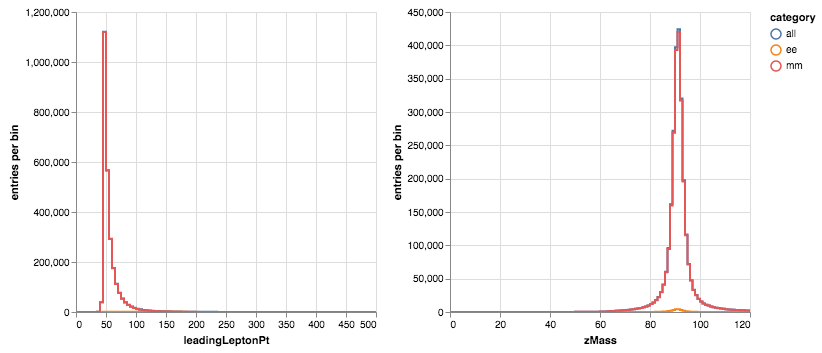

In [6]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists.values())
profile.clear()

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=1.,
            user_callback=callback, 
            user_params = {"weights_names":weights_names,
                           "weights_vals":weights_vals},
            histograms=all_hists.values()+[profile]
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)

In [7]:
def moment(df, n, binval='mid'):
    """
        df: DataFrame with single-level MultiIndex specifying binning, and a shape of (nbins, )
        n: n-th moment of distribution, ignoring (over/under/nan)flow bins
        binval in ['left', 'right', 'mid']: point in the bin to use as bin value
    """
    vals = np.array([getattr(b, binval) for b in df.index if type(b) is not str])[1:-1]
    weights = np.array(df)[1:-2]  # ignore nanflow (last bin)
    moment = sum(pow(vals, n)*weights) / sum(weights)
    return moment

def mean(df, binval='mid'):
    return moment(df, 1, binval)

def std(df, binval='mid'):
    return np.sqrt(max(moment(df, 2, binval) - moment(df, 1, binval)**2, 0.))

In [8]:
stripeThroughput = mean(profile.pandas()['count()']["plots"])
nWorkers = 180
processingTime = nevents_total/stripeThroughput/nWorkers
print "Stripe processing throughput: %.0f evt/s" % stripeThroughput
print "Total throughput: %.0f evt/s" % (nevents_total/(t2-t1), )
print "Striped server overhead: %.1f %%" % ((1-processingTime/(t2-t1))*100, )

Stripe processing throughput: 143394 evt/s
Total throughput: 3989896 evt/s
Striped server overhead: 84.5 %


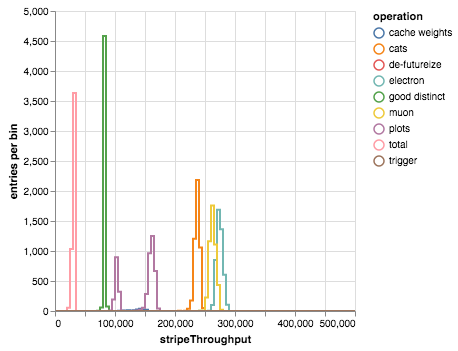

In [9]:
profile.overlay("operation").step("stripeThroughput", **display_opts).to(canvas)

In [10]:
a = profile.pandas()
for n in a.index.levels[0]:
    print "%20s %.0f" % (n, mean(a['count()'][n]))

       cache weights 137318
                cats 236892
        de-futureize nan
            electron 274387
       good distinct 82503
                muon 262892
               plots 143394
               total 31289
             trigger nan


/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
